Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)      

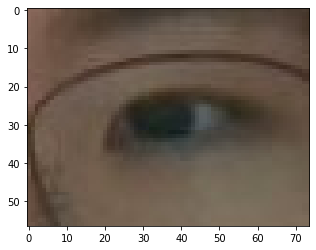

In [35]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

model = load_model('cnnCat2_mine.h5')
print(model.summary())

img_path = 'image.jpg'
img = image.load_img(img_path)
plt.imshow(img)

In [40]:
img = image.load_img(img_path, target_size=(24, 24), color_mode='grayscale')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 24, 24, 1)


In [41]:
#특정 입력영상에 대한 각 레이어의 Activation Map 출력
from keras import models

layer_outputs = [layer.output # for loop을 통해서 총 5개의 output이 들어가게 된다
                 for layer in model.layers[:7]]

activation_model = models.Model(inputs = model.input,
                                outputs = layer_outputs)

activations = activation_model.predict(img_tensor)

layer_names = []              # 층의 이름을 그래프 제목으로 사용, 모델에 있는 layer의 이름을 가져온다
for layer in model.layers[:7]:
    layer_names.append(layer.name)

images_per_row = 16

(1, 22, 22, 32)


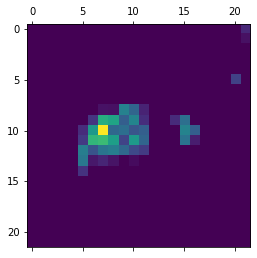

In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 15], 'viridis')

C:\Users\dahyun\Anaconda3\envs\dip\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


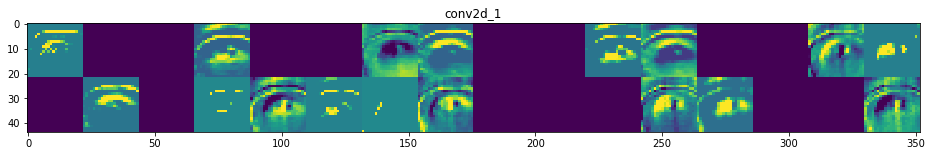

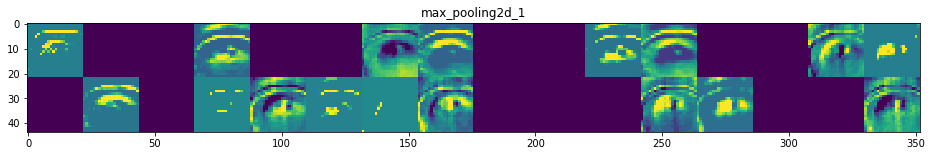

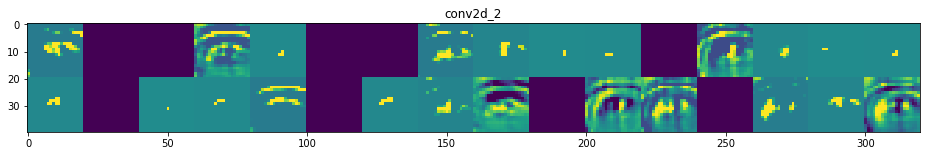

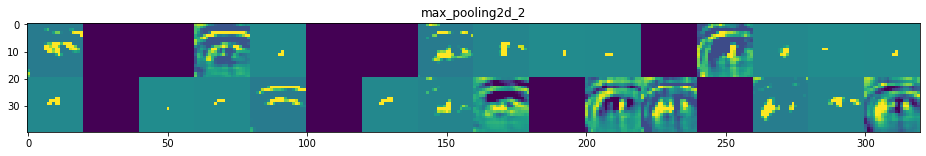

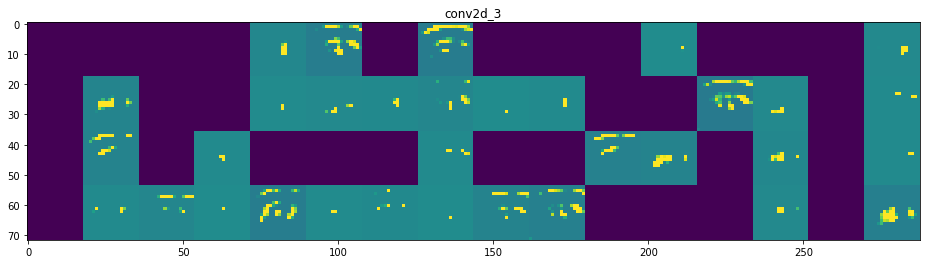

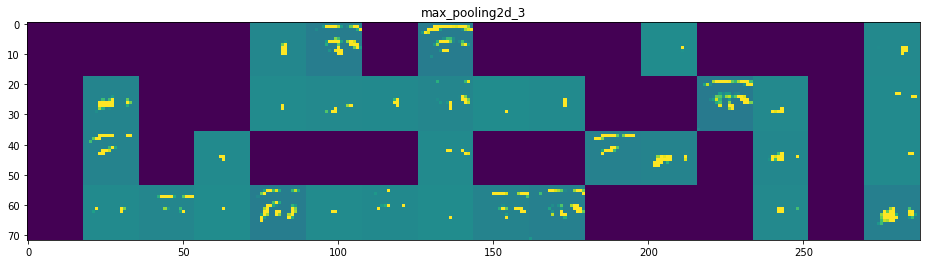

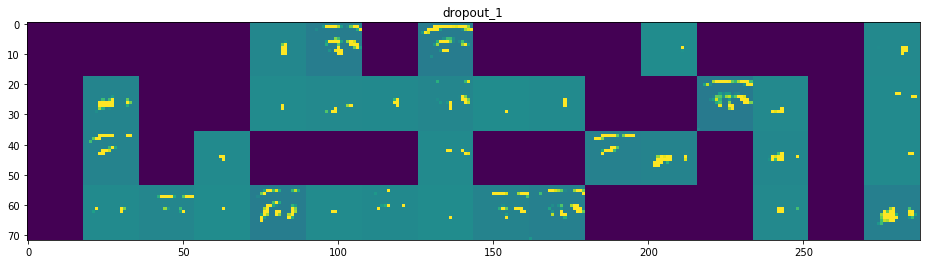

In [43]:
# 프로젝트 시 이 셀과 밑의 셀 반드시 포함하여 filter에 관한 내용을 분석하여야 한다
# feature map

for layer_name, layer_activation in zip(layer_names, activations): # zip:두 인자들을 하나의 짝으로 묶어준다/연결시켜준다

    n_features = layer_activation.shape[-1] # layer의 feature의 개수를 추출하여 n_features에 저장
    size = layer_activation.shape[1]        # 영상의 x,y사이즈가 동일해서 그 중 하나를 가져온 것


    n_cols = np.round(n_features / images_per_row).astype(np.uint8)
    # images_per_row = 16이므로 나눈 몫이 열의 개수가 된다
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # 영상의 픽셀 사이즈를 정함. 앞: 가로축 길이 / 뒤: 세로축의 길이
    # 즉, 전체 디스플레이할 크기를 의미한다


    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row] # for loop으로 하나씩 feature를 추출하는
            
            # 영상의 intensity를 조정하는 과정 (Normalize하는 과정)
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64  # 전체 영상의 variation을 일정하게 잡아주도록 64를 곱해준다. 일종의 histogram equalization과 비슷
            channel_image += 128 # 영상의 평균값이 128이 되도록 만들어 준다
            
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # 처리된 영상을 각 그리드에 뿌려준다
                         row * size : (row + 1) * size] = channel_image


    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show() # 하나의 layer가 완성되면 for loop이 멈추고 plt.show()로 출력된다. 즉, layer하나하나씩 출력된다

In [46]:
#각 레이어의 필터 특성 출력

from keras.applications import VGG16
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions

K.clear_session()
model = VGG16(weights='imagenet')

In [47]:
img_path = 'image.jpg'
img = image.load_img(img_path, target_size=(224, 224)) # 224 x 224 크기의 PIL 객체로 반환된다
x = image.img_to_array(img) # (224, 224, 3) 크기의 넘파이 float32 배열
x = np.expand_dims(x, axis=0) # 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 반환
x = preprocess_input(x) # 데이터 전처리 (채널별 컬러 정규화 수행)

In [48]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0]) # 제일 처음 3개를 가져와서 출력한다
# decode_predictions(preds, top=3) : ImageNet 데이터셋에 대한 예측 결과에서 3개의 최상위 항목을 반환한다

Predicted: [('n04523525', 'vault', 0.21669155), ('n02788148', 'bannister', 0.03275753), ('n04005630', 'prison', 0.029774707)]


위 결과를 분석해보면, 상위 3개의 예측 클래스는 vault, bannister, prison
1. vault : (20 % 확률)
2. bannister : (3 % 확률)
3. prison : (2 % 확률)

In [49]:
predict_output = model.output[:, np.argmax(preds[0])] # 예측 벡터에서 최대로 활성화된 항목(vault)의 클래스에서의 인덱스

last_conv_layer = model.get_layer('block5_conv3') # VGG16의 마지막 합성곱층의 특성맵
grads = K.gradients(predict_output, last_conv_layer.output)[0] 

pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 전체의 average가 가장 높은 gradient를 갖는 필터 하나를 선택한다

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x]) # vault 샘플 이미지를 주입하고 2개의 넘파이 배열을 얻는다

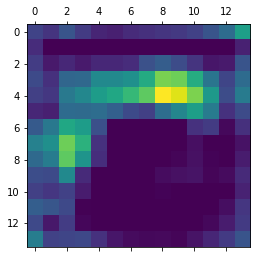

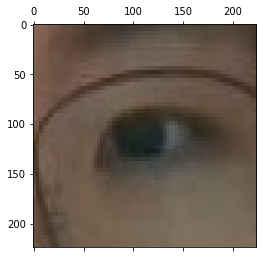

In [50]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # 출력 중 가장 gradient가 높은 것들을 곱한다(piggy_bank클래스에 대한 채널의 중요도를 특성맵 배열의 채널에 곱한다)
    
    heatmap = np.mean(conv_layer_output_value, axis=-1) # 마지막 axis가 feature에 해당되는 axis, 클래스 활성화 히트맵

# heatmap 후처리 : 시각화를 위해 heatmap을 0~1 사이로 정규화한다 
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap) # heatmap
plt.show()

plt.matshow(img) # 원본 영상
plt.show()
# heatmap: convolution layer에서 가장 값이 높은 것을 표시한다

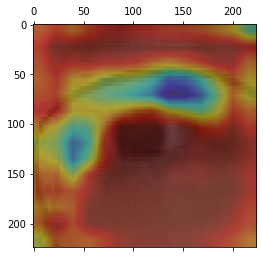

True

In [51]:
import cv2

background=image.img_to_array(img)
heatmap = cv2.resize(heatmap, (background.shape[1], background.shape[0])) # 영상 사이즈를 키운다
heatmap = np.uint8(255 * heatmap)                      # 전체 범위를 255로 키운다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 컬러맵을 바꿔줌

superimposed_img =  np.uint8(heatmap * 0.4+ background*0.6) # 영상 mixing. 두 비율의 합이 1이 되도록 설정해주면 된다 (0.4 + 0.6 = 1)
plt.matshow(superimposed_img)
plt.show()

cv2.imwrite('res_img.jpg', superimposed_img)